# SARIMA(p,d,q)(P,D,Q,s)
# Seasonal Autoregressive Integrated Moving Averages
datos contaminacion: promedio mensual de niveles de CO2, en partes por millon en hawai
no se incluira variables exogenas


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Herramientas
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # ETS Plots


# Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Dataset
df = pd.read_csv('co2_mm_mlo.csv')

In [5]:
df.head()
# la data del tiempo esta separada en colunnas

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [6]:
# Añadir una variable "date" tipo fecha
# definimos las etiquetas de acuerdo a python
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [7]:
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [8]:
# Hacer que la variable "data" sea el indice
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


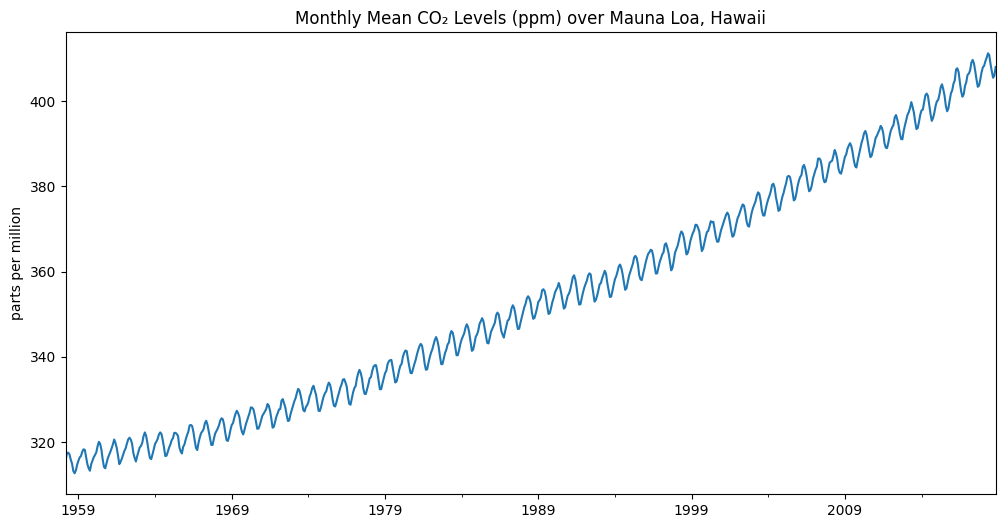

In [9]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

hay estacionalidad y tendencia ascendente.

para confirmar que hay estacionalidad podemos hacer una desconposicion en factor de tendencia, estacional y el factor residual.

### Descomposición en 3 factores

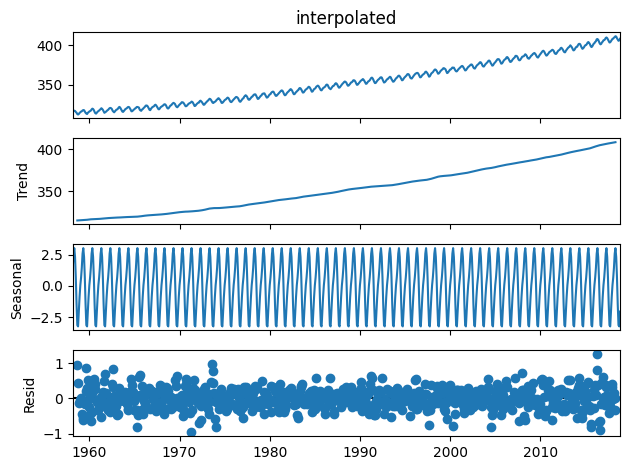

In [10]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

existe componente estacionaal, es decir tener en cuenta. usaremos un SARIMA

Aunque sea pequeña en comparación con la escala de los datos, hay una estacionalidad anual.

### Dividir en datos de entrenamiento y prueba

In [11]:
len(df)

729

In [12]:
# Prueba
train = df.iloc[:717]
test = df.iloc[717:]

In [15]:
train

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
2017-07-01,2017,7,2017.542,407.12,407.12
2017-08-01,2017,8,2017.625,405.13,405.13
2017-09-01,2017,9,2017.708,403.37,403.37


In [18]:
test

,year,month,decimal_date,average,interpolated
date,,,,,
2017-12-01,2017,12,2017.958,406.81,406.81
2018-01-01,2018,1,2018.042,407.96,407.96
2018-02-01,2018,2,2018.125,408.32,408.32
2018-03-01,2018,3,2018.208,409.41,409.41
2018-04-01,2018,4,2018.292,410.24,410.24
2018-05-01,2018,5,2018.375,411.24,411.24
2018-06-01,2018,6,2018.458,410.79,410.79
2018-07-01,2018,7,2018.542,408.71,408.71
2018-08-01,2018,8,2018.625,406.99,406.99


## Tomando un modelo especifico para interpretar.
### Modelo SARIMA(0,1,1)(1,0,1,12)

In [13]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.166
Date:                            Sat, 02 Sep 2023   AIC                            418.332
Time:                                    17:53:19   BIC                            436.627
Sample:                                03-01-1958   HQIC                           425.397
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3715      0.034    -11.066      0.000      -0.437      -0.306
ar.S.L12       0.9997      0.000   3514.753      0.000       0.999       1.000
ma.S.L12      -0.8661      0.022    -38.572      0.000      -0.910      -0.822
sigma2         0.0961      0.005     20.127      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.88
Prob(Q):                              0.70   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

todos son significativos. vamos a suponers que es el mejor modelo

In [14]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMA(0,1,1)(1,0,1,12) Predictions')

In [17]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.5834619, expected=406.81
predicted=407.7857019, expected=407.96
predicted=408.5315973, expected=408.32
predicted=409.4370057, expected=409.41
predicted=410.9942734, expected=410.24
predicted=411.5976078, expected=411.24
predicted=410.8174358, expected=410.79
predicted=409.1267217, expected=408.71
predicted=407.0255392, expected=406.99
predicted=405.5746841, expected=405.51
predicted=405.8451446, expected=406.0
predicted=407.37935  , expected=408.02


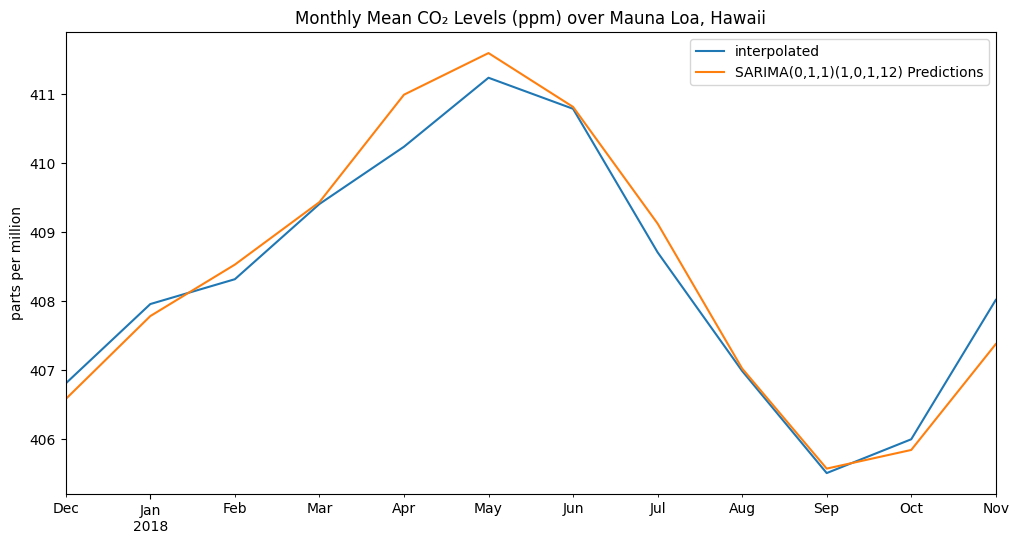

In [19]:
# Plot predictions against known values
title ='Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Reentrenar el modelo con todos los datos y predecir el futuro

In [20]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+36).rename('SARIMA(0,1,1)(1,0,1,12) Forecast')

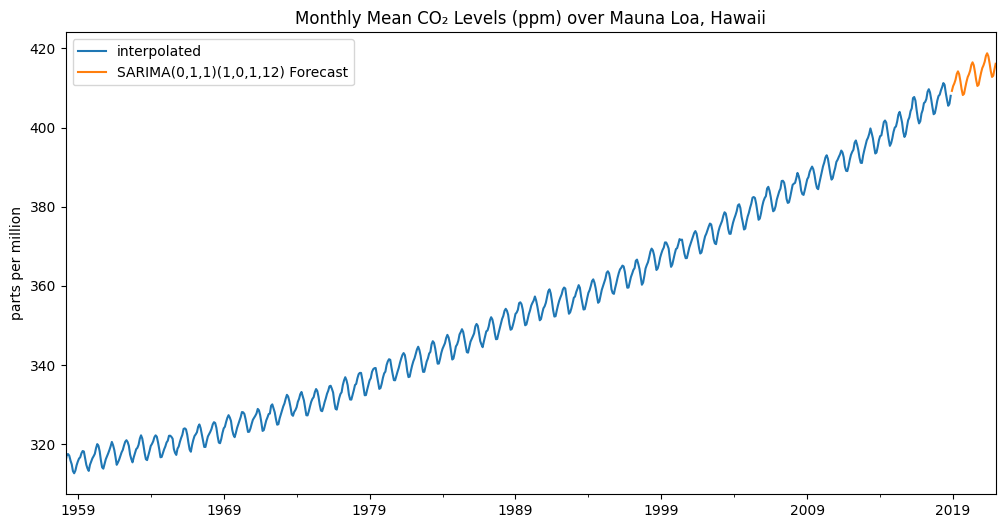

In [21]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [22]:
fcast

2018-12-01    409.267281
2019-01-01    410.462075
2019-02-01    411.155177
2019-03-01    412.085040
2019-04-01    413.545196
2019-05-01    414.201856
2019-06-01    413.465646
2019-07-01    411.722653
2019-08-01    409.673949
2019-09-01    408.220220
2019-10-01    408.520972
2019-11-01    410.120506
2019-12-01    411.552010
2020-01-01    412.746384
2020-02-01    413.439243
2020-03-01    414.368780
2020-04-01    415.828422
2020-05-01    416.484852
2020-06-01    415.748901
2020-07-01    414.006520
2020-08-01    411.958535
2020-09-01    410.505316
2020-10-01    410.805963
2020-11-01    412.404935
2020-12-01    413.835937
2021-01-01    415.029891
2021-02-01    415.722506
2021-03-01    416.651717
2021-04-01    418.110847
2021-05-01    418.767046
2021-06-01    418.031353
2021-07-01    416.289584
2021-08-01    414.242319
2021-09-01    412.789610
2021-10-01    413.090152
2021-11-01    414.688562
2021-12-01    416.119061
Freq: MS, Name: SARIMA(0,1,1)(1,0,1,12) Forecast, dtype: float64